In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import skew
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

pd.options.display.max_columns = 100
%matplotlib inline

In [2]:
training_data = pd.DataFrame.from_csv('train.csv')
test_data = pd.DataFrame.from_csv('test.csv')
target = 'SalePrice'

In [3]:
training_data_end_idx = len(training_data)
test_data_start_idx = len(training_data)

In [4]:
data = pd.concat([training_data, test_data])

In [5]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir,Condition1,Condition2,Electrical,EnclosedPorch,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotFrontage,LotShape,LowQualFinSF,MSSubClass,MSZoning,MasVnrArea,MasVnrType,MiscFeature,MiscVal,MoSold,Neighborhood,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,RoofMatl,RoofStyle,SaleCondition,SalePrice,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,856,854,0,NaN,3,1Fam,TA,No,706,0,GLQ,Unf,1,0,Gd,150,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,NaN,0,PConc,2,Typ,548,2,TA,RFn,TA,Attchd,2003,1710,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,8450,Inside,65,Reg,0,60,RL,196,BrkFace,NaN,0,2,CollgCr,61,5,7,Y,0,NaN,CompShg,Gable,Normal,208500,WD,0,Pave,8,856,AllPub,0,2003,2003,2008
2,1262,0,0,NaN,3,1Fam,TA,Gd,978,0,ALQ,Unf,0,1,Gd,284,Y,Feedr,Norm,SBrkr,0,TA,TA,MetalSd,MetalSd,NaN,TA,1,CBlock,2,Typ,460,2,TA,RFn,TA,Attchd,1976,1262,0,GasA,Ex,1Story,1,TA,Lvl,Gtl,9600,FR2,80,Reg,0,20,RL,0,None,NaN,0,5,Veenker,0,8,6,Y,0,NaN,CompShg,Gable,Normal,181500,WD,0,Pave,6,1262,AllPub,298,1976,1976,2007
3,920,866,0,NaN,3,1Fam,TA,Mn,486,0,GLQ,Unf,1,0,Gd,434,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,608,2,TA,RFn,TA,Attchd,2001,1786,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11250,Inside,68,IR1,0,60,RL,162,BrkFace,NaN,0,9,CollgCr,42,5,7,Y,0,NaN,CompShg,Gable,Normal,223500,WD,0,Pave,6,920,AllPub,0,2001,2002,2008
4,961,756,0,NaN,3,1Fam,Gd,No,216,0,ALQ,Unf,1,0,TA,540,Y,Norm,Norm,SBrkr,272,TA,TA,Wd Sdng,Wd Shng,NaN,Gd,1,BrkTil,1,Typ,642,3,TA,Unf,TA,Detchd,1998,1717,0,GasA,Gd,2Story,1,Gd,Lvl,Gtl,9550,Corner,60,IR1,0,70,RL,0,None,NaN,0,2,Crawfor,35,5,7,Y,0,NaN,CompShg,Gable,Abnorml,140000,WD,0,Pave,7,756,AllPub,0,1915,1970,2006
5,1145,1053,0,NaN,4,1Fam,TA,Av,655,0,GLQ,Unf,1,0,Gd,490,Y,Norm,Norm,SBrkr,0,TA,Gd,VinylSd,VinylSd,NaN,TA,1,PConc,2,Typ,836,3,TA,RFn,TA,Attchd,2000,2198,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,14260,FR2,84,IR1,0,60,RL,350,BrkFace,NaN,0,12,NoRidge,84,5,8,Y,0,NaN,CompShg,Gable,Normal,250000,WD,0,Pave,9,1145,AllPub,192,2000,2000,2008


Data pre-process

1) We first need to handle categorical data, the way to check if a variable is categorical data or numerical data is to check its data type and see if it's object, one thing to note is that we need to be cautious about date variable, even they are numerical variables we still need to regard them as categorical variable.

2) Then we need to handle missing data, there are many strategies we can use, to keep it simple, we fill na value with the corresponding mean value, that is, for any missing feature in the dataset, we use that's feature's mean valua as replacement.

3) Normalize data. It's always a good habit to normalize data before training any regression model
http://sebastianraschka.com/Articles/2014_about_feature_scaling.html

In [6]:
# Extract categorical data
categorical_variables = []
continuous_variables = []
for col in data.columns:
    if data[col].dtype == object or 'yr' in col.lower() or 'year' in col.lower():
        categorical_variables.append(col)
    elif col != target:
        continuous_variables.append(col)
        
data[categorical_variables] = data[categorical_variables].astype(object)

In [7]:
# Get dummy dataframe by using pandas.get_dumies() functions
dummy_df = pd.get_dummies(data[categorical_variables], dummy_na=True)

In [8]:
# Combine dataset and remove original categorical variable columns
data = pd.concat([data, dummy_df], axis=1)
for col in categorical_variables:
    del data[col]

In [9]:
features = data.columns.values.tolist()
features.remove(target)

Before we fill na values, let's take a look at how good/bad the data is

In [10]:
for col in features:
    num_nulls = len(data[data[col].isnull()])
    if num_nulls != 0:
        print('Feature {} has {} NAN values, out of {} data points.'.format(col, num_nulls, len(data)))

Feature BsmtFinSF1 has 1 NAN values, out of 2919 data points.
Feature BsmtFinSF2 has 1 NAN values, out of 2919 data points.
Feature BsmtFullBath has 2 NAN values, out of 2919 data points.
Feature BsmtHalfBath has 2 NAN values, out of 2919 data points.
Feature BsmtUnfSF has 1 NAN values, out of 2919 data points.
Feature GarageArea has 1 NAN values, out of 2919 data points.
Feature GarageCars has 1 NAN values, out of 2919 data points.
Feature LotFrontage has 486 NAN values, out of 2919 data points.
Feature MasVnrArea has 23 NAN values, out of 2919 data points.
Feature TotalBsmtSF has 1 NAN values, out of 2919 data points.


The dataset is not that bad, only few missing data, so filling these values with mean value won't have a significant influence on the dataset

In [11]:
data[features] = data[features].fillna(data.mean())

Normalize the dataset, make all the features in the same scale, with mean 0 and standard deviation 1, note we only need to normalize numerical data.

In [12]:
data[continuous_variables] = (data[continuous_variables] - data[continuous_variables].mean()) / data[continuous_variables].std(ddof=0)

Dataset is ready at this point, two regression models I'd like to try out here, one is Lasso and the other one is Ridge.

The biggest difference between Lasso and Ridge is the different strategies they use to avoid over-fitting, they have the same loss function, but their model complexity measuring functions are very different, Lasso uses l1 penalty which measures model complexity by looking at the sum of absolute values of coefficients while Ridge measures model complexity sum of square of coefficients.

Because of this difference, Lasso model can zero out coefficients thus does a feature selection, while Ridge does not.

More details see 
https://en.wikipedia.org/wiki/Lasso_(statistics)
https://en.wikipedia.org/wiki/Tikhonov_regularization

In [13]:
X_train = data[:training_data_end_idx][features]
X_test = data[test_data_start_idx:][features]
y = data[:training_data_end_idx]['SalePrice']

Here we use cross-validation to select the best penalty, note Lasso regression may take a long
time to converge for small l1 penalty

In [14]:
# Feature selection
coefs = []
for l1_penalty in [1, 3, 5, 10, 15, 30, 50, 70,100,150,250]:
    print('Training model with l1_penalty {}'.format(l1_penalty))
    error = np.sqrt(-cross_val_score(linear_model.Lasso(alpha=l1_penalty, max_iter=1000000), X_train, y, scoring="neg_mean_squared_error", cv=5)).mean()
    coefs.append(tuple((l1_penalty, error)))

Training model with l1_penalty 1
Training model with l1_penalty 3
Training model with l1_penalty 5
Training model with l1_penalty 10
Training model with l1_penalty 15
Training model with l1_penalty 30
Training model with l1_penalty 50
Training model with l1_penalty 70
Training model with l1_penalty 100
Training model with l1_penalty 150
Training model with l1_penalty 250


In [15]:
lasso_alphas = [x[0] for x in coefs]
ridge_errors = [x[1] for x in coefs]

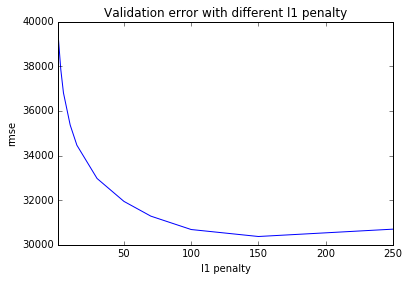

In [16]:
errors = pd.Series(ridge_errors, index=lasso_alphas)
errors.plot(title='Validation error with different l1 penalty')
plt.xlabel('l1 penalty')
plt.ylabel('rmse')

In [27]:
best_l2_penalty = errors.sort_values().head(1).index[0]

In [28]:
lasso_model = linear_model.Lasso(alpha=best_l2_penalty)
lasso_model.fit(X_train, y)

Lasso(alpha=150, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
lasso_coef = pd.Series(lasso_model.coef_, index = features)

In [31]:
print("Lasso picked " + str(sum(lasso_coef != 0)) + " variables and eliminated the other " +  str(sum(lasso_coef == 0)) + " variables")

Lasso picked 112 variables and eliminated the other 506 variables


In [59]:
# A deep look into the selected features
imp_coef = pd.concat([lasso_coef.sort_values().head(10),
                      lasso_coef.sort_values().tail(10)])

In [66]:
lasso_significant_pos10 = imp_coef.sort_values(ascending=False).index.values.tolist()[:10]

In [68]:
lasso_significant_pos10

['Neighborhood_NoRidge',
 'RoofMatl_WdShngl',
 'Neighborhood_StoneBr',
 'KitchenQual_Ex',
 'BsmtQual_Ex',
 'Neighborhood_NridgHt',
 'GrLivArea',
 'BsmtExposure_Gd',
 'OverallQual',
 'Neighborhood_Crawfor']

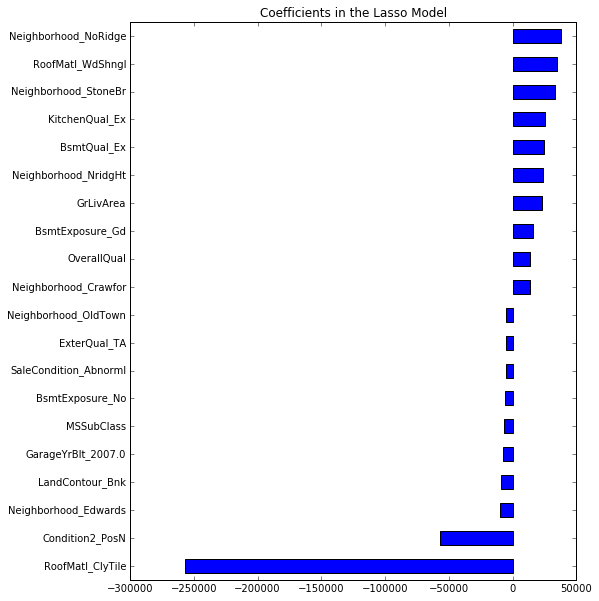

In [34]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Neighborhood_NoRidge
Neighborhood: Physical locations within Ames city limits
NoRidge	North ridge

In [35]:
training_data.groupby(['Neighborhood'])['SalePrice'].mean().sort_values(ascending=False).head(5)

Neighborhood
NoRidge    335295
NridgHt    316270
StoneBr    310499
Timber     242247
Veenker    238772
Name: SalePrice, dtype: int64

We see that indeed the house prices in NoRidge area have highest average price.
Let's take a look at the second most positive coefficient, RoofMatl_WdShngl

RoofMatl: Roof material

WdShngl: Wood Shingles

In [36]:
training_data.groupby(['RoofMatl'])['SalePrice'].mean().sort_values(ascending=False)

RoofMatl
WdShngl    390250
Membran    241500
WdShake    241400
Tar&Grv    185406
Metal      180000
CompShg    179803
ClyTile    160000
Roll       137000
Name: SalePrice, dtype: int64

Again, we see that houses with WdShngl roof have highest average prices!

Also note that RoofMatl_ClyTile has the most negative coefficient, houses with this roof material have the second lowest average house prices.

So, we think our feature selection results are reasonable


In [38]:
important_features = [features[i] for i in np.where(lasso_model.coef_ != 0)[0]]

Model evaluation

In [40]:
lasso_training_error = mean_squared_error(y, lasso_model.predict(X_train))**0.5

In [41]:
lasso_training_error

24291.600488337554

Now, let's try to train a Ridge regression model

In [42]:
coefs = []
for l2_penalty in [0.01, 0.5, 0.3, 1, 3, 5, 10, 15, 30, 50, 70,100,150,250]:
    print('Training model with l2_penalty {}'.format(l2_penalty))
    error = np.sqrt(-cross_val_score(linear_model.Ridge(alpha=l2_penalty), X_train, y, scoring="neg_mean_squared_error", cv=5)).mean()
    coefs.append(tuple((l2_penalty, error)))

Training model with l2_penalty 0.01
Training model with l2_penalty 0.5
Training model with l2_penalty 0.3
Training model with l2_penalty 1
Training model with l2_penalty 3
Training model with l2_penalty 5
Training model with l2_penalty 10
Training model with l2_penalty 15
Training model with l2_penalty 30
Training model with l2_penalty 50
Training model with l2_penalty 70
Training model with l2_penalty 100
Training model with l2_penalty 150
Training model with l2_penalty 250


In [43]:
ridge_alphas = [x[0] for x in coefs]
ridge_errors = [x[1] for x in coefs]

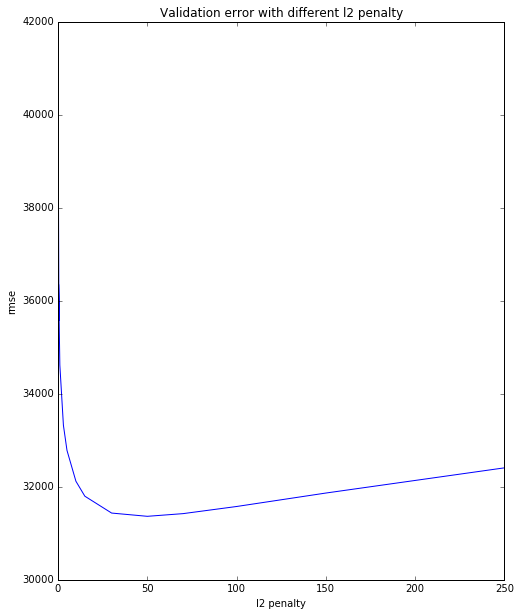

In [44]:
errors = pd.Series(ridge_errors, index=ridge_alphas)
errors.plot(title='Validation error with different l2 penalty')
plt.xlabel('l2 penalty')
plt.ylabel('rmse')

In [45]:
best_l2_penalty = errors.sort_values().head(1).index.values[0]

In [46]:
ridge_model = linear_model.Ridge(alpha=best_l2_penalty)
ridge_model.fit(X_train, y)

Ridge(alpha=50.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [47]:
ridge_coef = pd.Series(ridge_model.coef_, index = features)

In [48]:
imp_coef = pd.concat([ridge_coef.sort_values().head(10),
                      ridge_coef.sort_values().tail(10)])

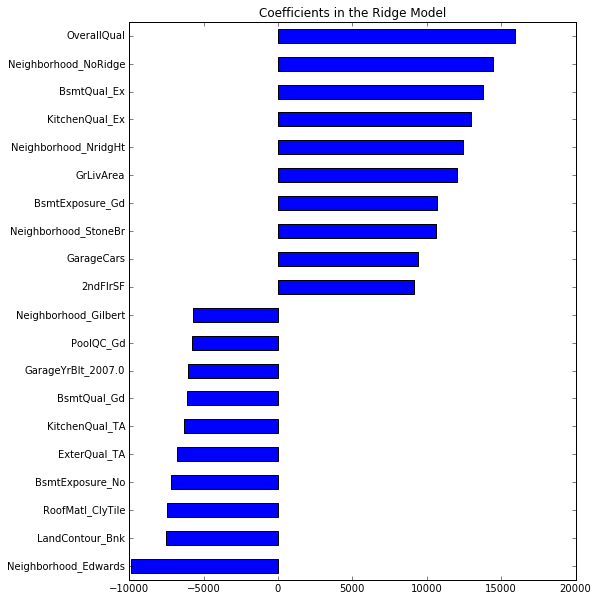

In [49]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

As you can see, Ridge regression gave more weights to OverallQual than Lasso regression, however, if you compare the first 10 most significant coefficients

In [57]:
ridge_coefficients_pos10 = imp_coef.sort_values(ascending=False)[:10].index.values.tolist()

In [71]:
ridge_training_error = mean_squared_error(y, ridge_model.predict(X_train))**0.5

In [73]:
ridge_training_error

26546.945864614161

In [74]:
# Model comparison

In terms of training error, lasso is better than ridge

In [76]:
lasso_training_error < ridge_training_error

True

In [83]:
lasso_coefs_pos10 = pd.Series(lasso_significant_pos10).reset_index()
ridge_coefs_pos10 = pd.Series(ridge_coefficients_pos10).reset_index()

In [91]:
lasso_coefs_pos10.columns = ['rank', 'feature']
ridge_coefs_pos10.columns = ['rank', 'feature']
lasso_coefs_pos10['rank'] = lasso_coefs_pos10['rank'] + 1
ridge_coefs_pos10['rank'] = ridge_coefs_pos10['rank'] + 1

In [97]:
lasso_coefs_pos10.merge(ridge_coefs_pos10, how='outer', on='feature', suffixes=['_in_lasso', '_in_ridge'])

,rank_in_lasso,feature,rank_in_ridge
0,1,Neighborhood_NoRidge,2
1,2,RoofMatl_WdShngl,NaN
2,3,Neighborhood_StoneBr,8
3,4,KitchenQual_Ex,4
4,5,BsmtQual_Ex,3
5,6,Neighborhood_NridgHt,5
6,7,GrLivArea,6
7,8,BsmtExposure_Gd,7
8,9,OverallQual,1
9,10,Neighborhood_Crawfor,NaN


As we can see, two features were kicked out(RoofMatl_WdShngl, Neighborhood_Crawfor) while another two features(GarageCars, 2ndFlrSF) were added in when training model from Lasso to Ridge. Other than that, the top 10 significant coefficients are pretty much the same no matter in what model.